In [1]:
# pycuda, numpy, scipy, matplotlib
import os
os.environ["CUDA_DEVICE"] = "3"
from pycuda.autoinit import context
import pycuda.driver as drv
from pycuda import cumath
from pycuda import gpuarray
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e, epsilon_0

from pypic import PyPIC_GPU as PIC
from meshing import RectMesh3D
from poisson_solver import FFT_solver as FFT

%matplotlib inline

PyKLU not found


## define mesh, poisson solver and pic

In [2]:
nx, ny, nz = 32, 64, 128
nx, ny, nz = 256, 256, 64
dx = dy = dz = 0.1
x_aper = nx*dx/2.
y_aper = ny*dy/2.
z_aper = nz*dz/2.
mesh = RectMesh3D(-x_aper, -y_aper, -z_aper , dx, dy, dz, nx, ny, nz, mathlib=cumath)
poissonsolver = FFT.GPUFFTPoissonSolver(mesh)
pic = PIC(mesh, poissonsolver, context=context)

## generate particles
make sure they're inside the mesh boundaries

In [3]:
N = 500*1024
np.random.seed(0)
mesh_center_x = mesh.x0 + 0.5*mesh.nx*mesh.dx
mesh_center_y = mesh.y0 + 0.5*mesh.ny*mesh.dy
mesh_center_z = mesh.z0 + 0.5*mesh.nz*mesh.dz
sigma = 0.4
xx = np.random.normal(mesh_center_x, sigma, N)
yy = np.random.normal(mesh_center_y, sigma, N)
zz = np.random.normal(mesh_center_z, sigma, N)
assert((xx > mesh.x0).all() and (xx < mesh.x0 + mesh.nx*mesh.dx).all())
assert((yy > mesh.y0).all() and (yy < mesh.y0 + mesh.ny*mesh.dy).all())
assert((zz > mesh.z0).all() and (zz < mesh.z0 + mesh.nz*mesh.dz).all())
xx = gpuarray.to_gpu(xx)
yy = gpuarray.to_gpu(yy)
zz = gpuarray.to_gpu(zz)

### convenience wrapper which runs the pic and stores all intermediate results

In [4]:
def test_solver(new_solver, xx, yy, zz, charge=e, x_probe=None, y_probe=None, z_probe=None):
    '''
    Return rho, Phi, efx, efy, efz, Ex, Ey, Ez
    '''
    if x_probe == None:
        x_probe = xx
    if y_probe == None:
        y_probe = yy
    if z_probe == None:
        z_probe = zz
    mesh_charges = new_solver.particles_to_mesh(xx, yy, zz, charge=charge)
    rho = mesh_charges/new_solver.mesh.volume_elem
    phi = new_solver.poisson_solve(rho)
    mesh_e_fields = new_solver.get_electric_fields(phi)
    efx = mesh_e_fields[0]
    efy = mesh_e_fields[1]
    efz = mesh_e_fields[2]
    mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_probe, y_probe, z_probe])
    fields = new_solver.field_to_particles(*mesh_fields_and_mp_coords)
    Ex = fields[0]
    Ey = fields[1]
    Ez = fields[2]
    return rho, phi, efx, efy, efz, Ex, Ey, Ez

## Run the pic and store the results

In [5]:
rho, phi, efx, efy, efz, Ex, Ey, Ez = test_solver(pic, xx, yy, zz)

### Analytical solution for a round beam in free space

In [6]:
def _phin_round(x, y, z, sig_r):
    '''Return phi / Q for a round distribution with
    sigma_x == sigma_y == sigma_z == sig_r .
    '''
    r = np.sqrt(x**2 + y**2 + z**2)
    return erf(r/(np.sqrt(2)*sig_r)) / (4*np.pi*epsilon_0 * r)

from scipy.special import erf
extent = np.array([mesh.x0, mesh.x0+mesh.nx*mesh.dx,
                   mesh.y0, mesh.y0+mesh.ny*mesh.dy,
                   mesh.z0, mesh.z0+mesh.nz*mesh.dz])
z, y, x = np.meshgrid(np.linspace(extent[4], extent[5], mesh.nz),
                      np.linspace(extent[2], extent[3], mesh.ny),
                      np.linspace(extent[0], extent[1], mesh.nx),
                      indexing="ij")
xr = x - mesh_center_x - 0.5*mesh.dx
yr = y - mesh_center_y - 0.5*mesh.dy
zr = z - mesh_center_z - 0.5*mesh.dz
sig_x = sigma
phi_analytic = _phin_round(xr, yr, zr, sig_x) * N * e

## Plot the results

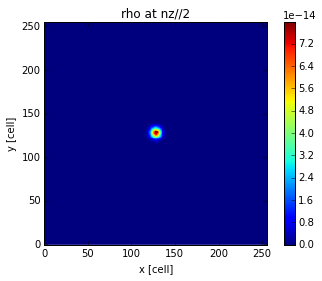

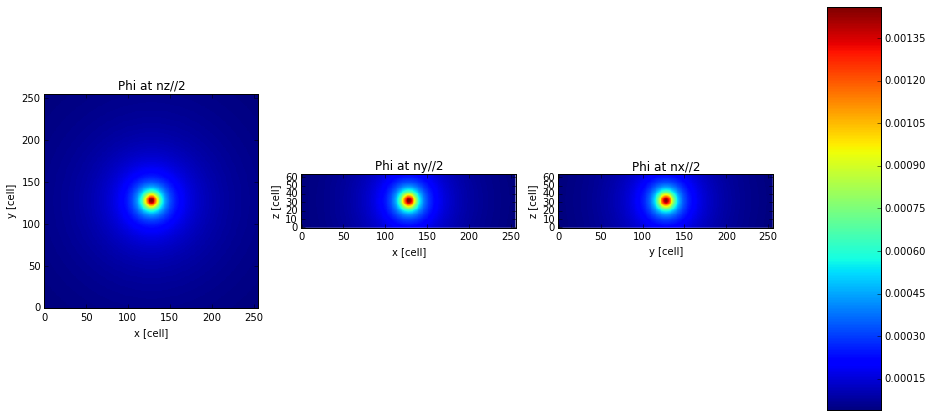

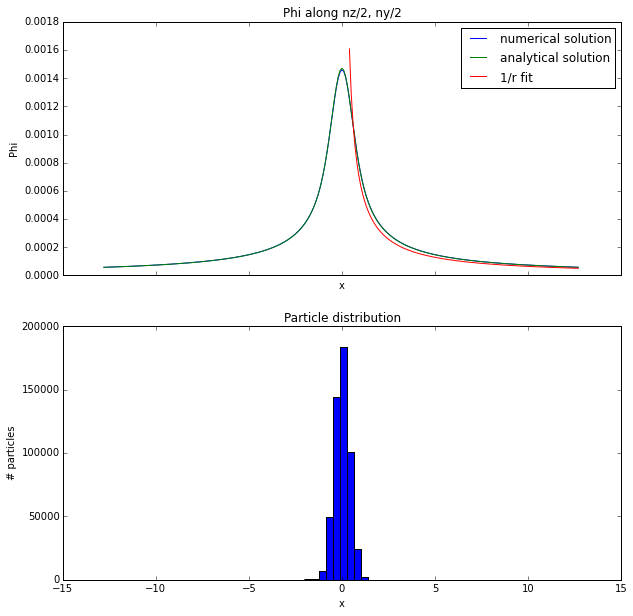

In [7]:


# rho at nz//2
plt.figure()
plt.imshow(rho.get()[mesh.nz//2], origin='lower', interpolation='none')
plt.colorbar()
plt.title('rho at nz//2')
plt.xlabel('x [cell]')
plt.ylabel('y [cell]')
plt.show()

# Phi 2d
f, axarr = plt.subplots(1,3)
f.set_figheight(8)
f.set_figwidth(15)
im = axarr[0].imshow(phi.get()[mesh.nz//2], origin='lower', interpolation='none')
axarr[0].set_title('Phi at nz//2')
axarr[0].set_xlabel('x [cell]')
axarr[0].set_ylabel('y [cell]')
axarr[1].imshow(phi.get()[:,mesh.ny//2,:], origin='lower', interpolation='none')
axarr[1].set_title('Phi at ny//2')
axarr[1].set_xlabel('x [cell]')
axarr[1].set_ylabel('z [cell]')
axarr[2].imshow(phi.get()[:,:,nx//2], origin='lower', interpolation='none')
axarr[2].set_title('Phi at nx//2')
axarr[2].set_xlabel('y [cell]')
axarr[2].set_ylabel('z [cell]')
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)
plt.show()

# Phi compare with analytical results and a 1/r fit
def fn(r, a):
    '''Analytical solution fit'''
    return a*(1./r)
xxx = np.arange(mesh.x0, mesh.x0+mesh.nx*mesh.dx, dx)
start_fit = mesh.nx/2 + 4
fit_xxx = xxx[start_fit:]
popt_GPU, _ = curve_fit(fn, fit_xxx, phi.get()[mesh.nz//2, mesh.ny//2, start_fit:])
f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(10)
f.set_figwidth(10)
axarr[0].set_title('Phi along nz/2, ny/2')
axarr[0].plot(xxx,phi.get()[mesh.nz//2, mesh.ny//2,:],label = 'numerical solution')
axarr[0].plot(xxx, phi_analytic[mesh.nz//2, mesh.ny//2, :], label= 'analytical solution')
axarr[0].plot(fit_xxx, fn(fit_xxx, *popt_GPU), label='1/r fit')
axarr[0].set_ylabel('Phi')
axarr[0].set_xlabel('x')

axarr[0].legend()
axarr[1].set_title('Particle distribution')
axarr[1].hist(xx.get())
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('# particles')

plt.show()
